In [2]:
import torch
from torch import nn
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from torch.optim import AdamW
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

/Users/yb/anaconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
torch.manual_seed(42)
    
# Set device (GPU if available, else CPU)
device = (
    "mps" 
    if torch.backends.mps.is_available() 
    else "cuda" 
    if torch.cuda.is_available() 
    else "cpu"
)
device = torch.device(device)
print(f"Using device: {device}")

Using device: cpu


In [4]:
df = pd.read_csv("sentiment_annotated_with_texts.csv")
df.head(5)

,published_at,ticker,true_sentiment,title,author,url,source,text,finbert_sentiment,finbert_sent_score
0,2023-01-12 07:47:00,EURCHF,Positive,Euro to benefit from the ECBs pronounced hawki...,FXStreet Insights Team,https://www.fxstreet.com/news/euro-to-benefit-...,FX Street,The Euro was able to appreciate particularly s...,Positive,0.85
1,2023-01-12 10:34:00,EURCHF,Positive,EURCHF Trend higher may remain in place – ING,FXStreet Insights Team,https://www.fxstreet.com/news/eur-chf-trend-hi...,FX Street,EUR/CHF yesterday broke above 1.00. Economists...,Positive,0.51
2,2023-01-12 11:40:00,EURCHF,Neutral,Does a jump in EURCHF point to a break above 1...,FXStreet Insights Team,https://www.fxstreet.com/news/does-a-jump-in-e...,FX Street,EUR/CHF vaults parity for the first time since...,Neutral,0.37
3,2023-01-12 15:32:00,EURCHF,Positive,EURCHF could extend its advance back to levels...,FXStreet Insights Team,https://www.fxstreet.com/news/eur-chf-could-ex...,FX Street,EUR/CHF climbs back above parity. Economists a...,Positive,0.64
4,2023-01-13 11:37:00,EURCHF,Positive,EURCHF to head higher towards 10130 and projec...,FXStreet Insights Team,https://www.fxstreet.com/news/eur-chf-to-head-...,FX Street,EUR/CHF has broken out above the sideways rang...,Positive,0.83


In [5]:
#currency pairs avaiable

pairs= df['ticker'].unique()
pairs

array(['EURCHF', 'USDJPY', 'GBPUSD', 'EURUSD', 'AUDUSD'], dtype=object)

## Data Preprocessing

In [6]:
# missing values
df.isnull().sum()
df = df.dropna()

#label encoding
label_map = {"Positive": 2, "Neutral": 1, "Negative": 0}
df["label"] = df["true_sentiment"].map(label_map)
 

#80-20 Train-test split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['title'], df['label'], test_size=0.2, random_state=42
)


## FinBERT model fine-tuning

In [7]:
#FinBERT Tokenizer
tokenizer = BertTokenizer.from_pretrained("ProsusAI/finbert")
 
def tokenize_data(texts, tokenizer, max_length=64):
    return tokenizer(
        list(texts),
        padding="max_length",
        truncation=True,
        max_length=max_length,
        return_tensors="pt"
    )
 
class ForexDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=64):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts.iloc[idx],
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.tensor(self.labels.iloc[idx], dtype=torch.long)
        }


In [8]:
train_dataset = ForexDataset(train_texts, train_labels, tokenizer)
val_dataset = ForexDataset(val_texts, val_labels, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)


In [9]:
#FinBERT Model
model = BertForSequenceClassification.from_pretrained("ProsusAI/finbert", num_labels=3)

#use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

### Warning: the cell below takes 40 mins to complete

In [10]:
 
#Optimizer & Loss Function
optimizer = AdamW(model.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss()

# Training function
def train_model(model, train_loader, val_loader, optimizer, loss_fn, epochs=3):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch in train_loader:
            input_ids, attention_mask, labels = (
                batch['input_ids'].to(device),
                batch['attention_mask'].to(device),
                batch['labels'].to(device)
            )
            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask)
            loss = loss_fn(outputs.logits, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch + 1}: Loss {total_loss / len(train_loader)}")


train_model(model, train_loader, val_loader, optimizer, loss_fn)


Epoch 1: Loss 1.0933147223099418
Epoch 2: Loss 0.8372804514739824
Epoch 3: Loss 0.5000748872109081


## Evaluate performance of Tuned Model

#### warning: the cell below taks 10 mins to complete

In [15]:
 #insure the model is in evaluation mode
model.eval()

# Tokenize and predict sentiment for headlines
def predict_title_sentiment(titles, model, tokenizer, device):
    predictions = []
    
    with torch.no_grad():
        for title in titles:
            encoding = tokenizer(title, padding="max_length", truncation=True, max_length=64, return_tensors="pt").to(device)
            outputs = model(encoding["input_ids"], attention_mask=encoding["attention_mask"])
            predicted_label = torch.argmax(outputs.logits, dim=1).cpu().item()
            predictions.append(predicted_label)

    return predictions

# Run predictions on the title column
predicted_labels = predict_title_sentiment(df['title'], model, tokenizer, device)

# True sentiment values for evaluation
true_labels = df['label']

# Compute evaluation metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')
auc = roc_auc_score(pd.get_dummies(true_labels), pd.get_dummies(predicted_labels), average='weighted', multi_class='ovr')

#evaluation metrics
print("Evaluation Metrics for FinBERT on Titles:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC Score: {auc:.4f}")



Evaluation Metrics for FinBERT on Titles:
Accuracy: 0.8691
Precision: 0.8762
Recall: 0.8691
F1-Score: 0.8686
AUC Score: 0.9024


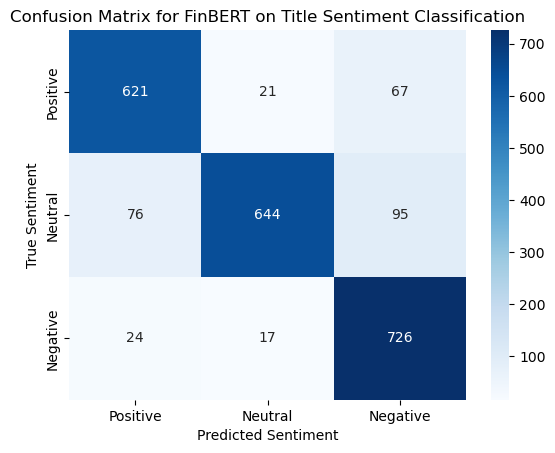

In [14]:
#confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_map.keys(), yticklabels=label_map.keys())
plt.xlabel("Predicted Sentiment")
plt.ylabel("True Sentiment")
plt.title("Confusion Matrix for FinBERT on Title Sentiment Classification")
plt.show()


### results of untuned model

#### warning: the cell below taks 10 mins to complete

In [18]:
# Load pre-trained (untuned) FinBERT model and tokenizer
model_name = "ProsusAI/finbert"
tokenizer = BertTokenizer.from_pretrained(model_name)
untuned_model = BertForSequenceClassification.from_pretrained(model_name, num_labels=3)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
untuned_model.to(device)
untuned_model.eval()

# Function to predict sentiment for titles using untuned FinBERT
def predict_untuned_title_sentiment(titles, model, tokenizer, device):
    predictions = []
    
    with torch.no_grad():
        for title in titles:
            encoding = tokenizer(title, padding="max_length", truncation=True, max_length=64, return_tensors="pt").to(device)
            outputs = model(encoding["input_ids"], attention_mask=encoding["attention_mask"])
            predicted_label = torch.argmax(outputs.logits, dim=1).cpu().item()
            predictions.append(predicted_label)
    
    return predictions

#Run predictions on the title column using untuned FinBERT
predicted_labels_untuned = predict_untuned_title_sentiment(df['title'], untuned_model, tokenizer, device)



In [19]:

# True sentiment values for evaluation
true_labels = df['label']

# Compute evaluation metrics for untuned FinBERT
accuracy = accuracy_score(true_labels, predicted_labels_untuned)
precision = precision_score(true_labels, predicted_labels_untuned, average='weighted')
recall = recall_score(true_labels, predicted_labels_untuned, average='weighted')
f1 = f1_score(true_labels, predicted_labels_untuned, average='weighted')
auc = roc_auc_score(pd.get_dummies(true_labels), pd.get_dummies(predicted_labels_untuned), average='weighted', multi_class='ovr')

#evaluation metrics
print("Evaluation Metrics for Untuned FinBERT on Titles:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC Score: {auc:.4f}")


Evaluation Metrics for Untuned FinBERT on Titles:
Accuracy: 0.2309
Precision: 0.2356
Recall: 0.2309
F1-Score: 0.2321
AUC Score: 0.4237


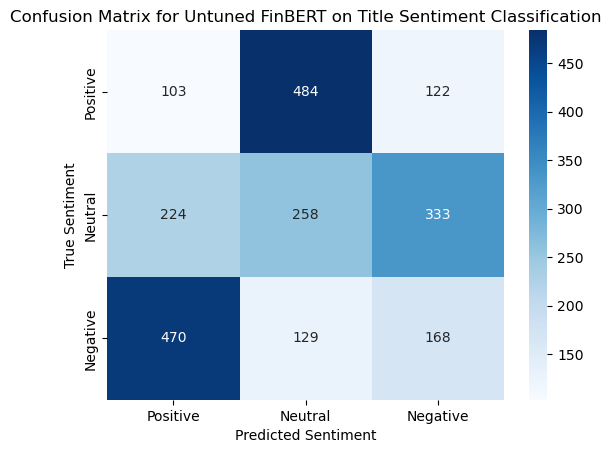

In [20]:
#confusion matrix
cm = confusion_matrix(true_labels, predicted_labels_untuned)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_map.keys(), yticklabels=label_map.keys())
plt.xlabel("Predicted Sentiment")
plt.ylabel("True Sentiment")
plt.title("Confusion Matrix for Untuned FinBERT on Title Sentiment Classification")
plt.show()


## Apply tuned model on Full-text

#### warning: the cell below taks 20 mins to complete

In [23]:
#function to randomly sample text chunks
def sample_random_chunks(text, chunk_size=128, num_chunks=5):
    words = text.split()
    n = len(words)
    
    if n <= chunk_size:
        return [" ".join(words)]  #if text is too short, use it as is
    
    start_indices = random.sample(range(0, n - chunk_size), min(num_chunks, n // chunk_size))
    return [" ".join(words[i:i + chunk_size]) for i in start_indices]

#func to apply length-normalized sentiment adjustment with random chunks
def predict_sentiment_with_length_adjustment(text, model, tokenizer, device):
    model.eval()
    chunks = sample_random_chunks(text)
    sentiment_scores = []
    chunk_lengths = []
    
    with torch.no_grad():
        for chunk in chunks:
            encoding = tokenizer(chunk, padding="max_length", truncation=True, max_length=64, return_tensors="pt")
            input_ids, attention_mask = encoding["input_ids"].to(device), encoding["attention_mask"].to(device)
            outputs = model(input_ids, attention_mask=attention_mask)
            probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1).cpu().numpy()[0]
            
            #sentiment score S_i = -p(neg) + p(pos)
            S_i = -probabilities[0] + probabilities[2]
            sentiment_scores.append(S_i)
            chunk_lengths.append(len(chunk.split()))
    
    #weight W_i = 1 / (1 + log(1 + L_i))
    weights = [1 / (1 + np.log(1 + L)) for L in chunk_lengths]
    
    #overall length-normalized sentiment score S_T
    S_T = np.sum(np.array(sentiment_scores) * np.array(weights)) / np.sum(weights)
    
    #convert to sentiment class
    if S_T > 0.1:
        return 2  #Positive
    elif S_T < -0.1:
        return 0  #Negative
    else:
        return 1  #Neutral

 
df['text_sentiment'] = df['text'].apply(lambda x: predict_sentiment_with_length_adjustment(x, model, tokenizer, device))



In [24]:
df.head(5)

,published_at,ticker,true_sentiment,title,author,url,source,text,finbert_sentiment,finbert_sent_score,label,text_sentiment
0,2023-01-12 07:47:00,EURCHF,Positive,Euro to benefit from the ECBs pronounced hawki...,FXStreet Insights Team,https://www.fxstreet.com/news/euro-to-benefit-...,FX Street,The Euro was able to appreciate particularly s...,Positive,0.85,2,0
1,2023-01-12 10:34:00,EURCHF,Positive,EURCHF Trend higher may remain in place – ING,FXStreet Insights Team,https://www.fxstreet.com/news/eur-chf-trend-hi...,FX Street,EUR/CHF yesterday broke above 1.00. Economists...,Positive,0.51,2,0
2,2023-01-12 11:40:00,EURCHF,Neutral,Does a jump in EURCHF point to a break above 1...,FXStreet Insights Team,https://www.fxstreet.com/news/does-a-jump-in-e...,FX Street,EUR/CHF vaults parity for the first time since...,Neutral,0.37,1,1
3,2023-01-12 15:32:00,EURCHF,Positive,EURCHF could extend its advance back to levels...,FXStreet Insights Team,https://www.fxstreet.com/news/eur-chf-could-ex...,FX Street,EUR/CHF climbs back above parity. Economists a...,Positive,0.64,2,2
4,2023-01-13 11:37:00,EURCHF,Positive,EURCHF to head higher towards 10130 and projec...,FXStreet Insights Team,https://www.fxstreet.com/news/eur-chf-to-head-...,FX Street,EUR/CHF has broken out above the sideways rang...,Positive,0.83,2,2


## Headline Performance evaluation

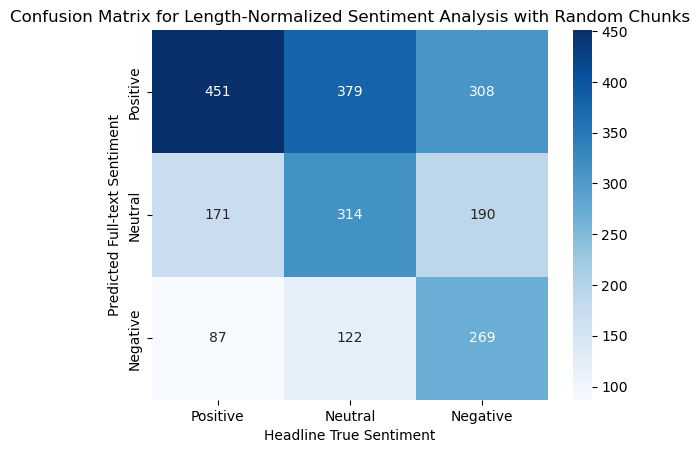

Evaluation Metrics:
Accuracy: 0.4513
Precision: 0.5027
Recall: 0.4513
F1-Score: 0.4569
AUC Score: 0.5958


In [25]:
#confusion matrix
true_labels = df['text_sentiment']
predicted_labels = df['label']

cm = confusion_matrix(true_labels, predicted_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_map.keys(), yticklabels=label_map.keys())
plt.xlabel("Headline True Sentiment")
plt.ylabel("Predicted Full-text Sentiment")
plt.title("Confusion Matrix for Length-Normalized Sentiment Analysis with Random Chunks")
plt.show()

#evaluation metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')
auc = roc_auc_score(pd.get_dummies(true_labels), pd.get_dummies(predicted_labels), average='weighted', multi_class='ovr')

print("Evaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC Score: {auc:.4f}")

In [26]:
source_accuracies = {}
sources = df['source'].unique()

for source in sources:
    source_data = df[df['source'] == source]
    true_labels = source_data['text_sentiment']
    predicted_labels = source_data['label']
    source_accuracies[source] = accuracy_score(true_labels, predicted_labels)
 

print("News Source Accuracy:")
for source, acc in source_accuracies.items():
    print(f"{source}: {acc:.4f}")
 

News Source Accuracy:
FX Street: 0.4493
Forex Live: 0.4717
